In [1]:
from datetime import datetime, timedelta
from tqdm import tqdm
import itertools

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [3]:
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

# warnings.filterwarnings("ignore", category=DeprecationWarning) 
# warnings.filterwarnings('ignore', category=ValueWarning)
# warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA', FutureWarning)

# Data

## Dataframes

In [4]:
df = pd.read_csv('../../data/BTCUSDT-minute.csv')

In [5]:
df

,timestamp,open,high,low,close,volume
0,2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183
1,2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000
2,2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074
3,2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008
4,2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796
...,...,...,...,...,...,...
1988733,2021-06-03 20:24:00,38665.26,38689.56,38655.91,38682.52,14.795718
1988734,2021-06-03 20:25:00,38682.52,38682.53,38643.07,38649.70,16.778473
1988735,2021-06-03 20:26:00,38649.69,38682.52,38649.69,38682.52,15.709853
1988736,2021-06-03 20:27:00,38682.52,38682.69,38640.40,38649.38,23.010205


In [6]:
# df.to_csv('../../bitcoin-printer/data/BTCUSDT-minute.csv', index=False)

In [7]:
df1 = df.drop(['open', 'high', 'low'], axis=1).reset_index(drop=True)

In [8]:
df1['returns'] = df1['close'].pct_change()
df1.dropna(axis=0, inplace=True)

In [9]:
df2 = df1.iloc[::60].reset_index(drop=True)

In [11]:
# df2

In [12]:
df3 = df2.iloc[30000:].reset_index(drop=True)

In [13]:
# df3

## Plotting

Text(0, 0.5, 'close')

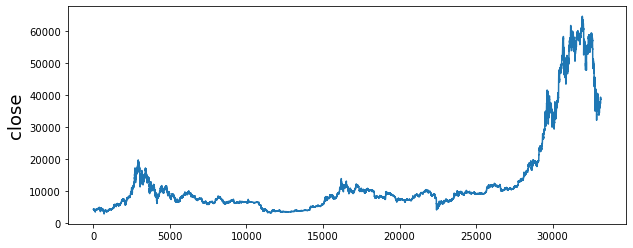

In [42]:
plt.figure(figsize=(10,4))
plt.plot(df2['close'])
plt.ylabel('close', fontsize=18)

Text(0, 0.5, 'close')

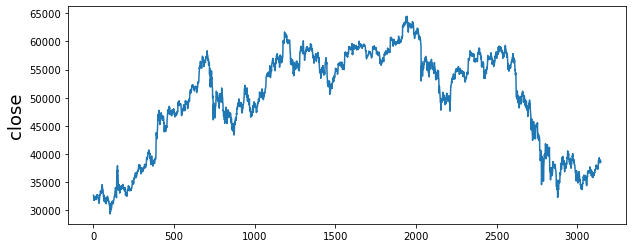

In [22]:
plt.figure(figsize=(10,4))
plt.plot(df3['close'])
plt.ylabel('close', fontsize=18)

Text(0, 0.5, 'returns')

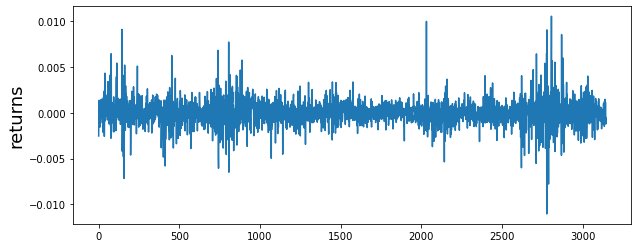

In [21]:
plt.figure(figsize=(10,4))
plt.plot(df3['returns'])
plt.ylabel('returns', fontsize=18)

In [29]:
result = adfuller(df3['returns'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items(): print(f'   {key}, {value}')  

ADF Statistic: -56.563246923327284
p-value: 0.0
   1%, -3.4324309683280463
   5%, -2.8624594436604216
   10%, -2.5672594413875207


## Autocorrelation

<Figure size 720x720 with 0 Axes>

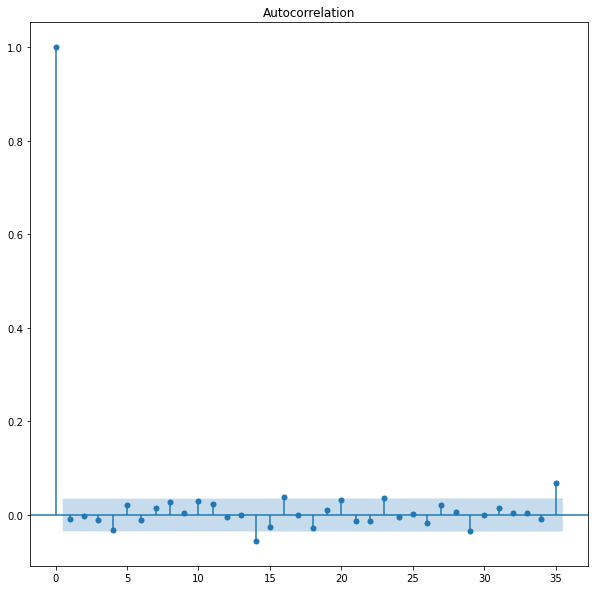

In [19]:
plt.figure(figsize=(10,10))
fig = plot_acf(df3['returns'])
fig.set_size_inches(10,10)

<Figure size 720x720 with 0 Axes>

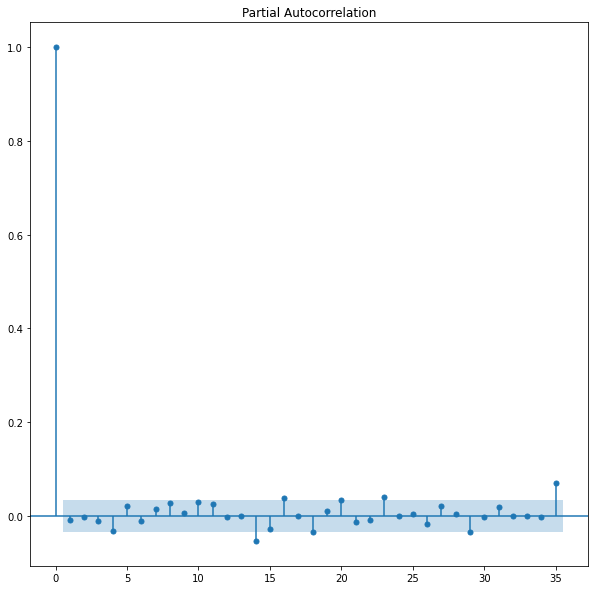

In [20]:
plt.figure(figsize=(10,10))
fig = plot_pacf(df3['returns'])
fig.set_size_inches(10,10)

# Random

In [11]:
run_simulation(df2['returns'][30000:], df2['close'][30000:], 100, 0.5, None, verbose=False)

100%|██████████| 3132/3132 [00:00<00:00, 29725.84it/s]


107.6191950344062

In [13]:
final_amts = [run_simulation(df2['returns'][30000:], df2['close'][30000:], 100, 0.5, None, verbose=False) for _ in range(500)]

100%|██████████| 3132/3132 [00:00<00:00, 30782.80it/s]


Text(0.5, 1.0, 'Avg: $109.81\nSD: $28.46')

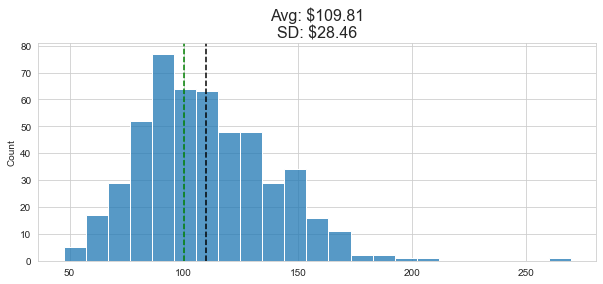

In [14]:
plt.figure(figsize=(10,4))
sns.set_style("whitegrid")
sns.histplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=16)

# ARMA v1

## Model

In [58]:
def arma_model(returns, prices, amt, order, threshold, verbose=False):

    if type(order) == float:
        threshold = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    for t, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        
        if curr_holding:
            curr_holding = False
            sell_price = prices.loc[t]
            realized_return = (sell_price - buy_price) / buy_price
            amt *= (1+realized_return)
            events_list.append(('s', t, realized_return))
            
            if verbose:
                print('sell $%s'%sell_price)
                #print('Predicted Return: %s'%round(pred,4))
                print('final return %s'%(round(realized_return, 4)))
                print('---------------------------------------')
            continue
        
        curr_data = returns[:t]
        
        if type(order) == tuple:
            try:
                model = ARIMA(curr_data, order=order).fit()
                pred = model.forecast().reset_index(drop=True)[0]
            except Exception as e:
                pred = threshold - 1
                print(e)

        if (type(order) == float and np.random.random() < order) \
        or (type(order) == tuple and pred > threshold):
            
            curr_holding = True
            buy_price = prices.loc[t]
            events_list.append(('b', t))
            
            if verbose:
                print('buy $%s'%buy_price)
                
    if verbose:
        print('total $%s'%round(amt,2))
    
    return (model, amt)

## AR(1)

In [50]:
arma_model(df3['returns'], df3['close'], 100, (1,0,0), 0, verbose=False)

100%|██████████| 3132/3132 [06:31<00:00,  7.99it/s]


(<statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x7fac7d2bb8e0>,
 84.62889174625569)

In [51]:
arma_model(df3['returns'], df3['close'], 100, (1,0,1), 0, verbose=False)

  0%|          | 0/3132 [00:00<?, ?it/s]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
100%|██████████| 3132/3132 [10:46<00:00,  4.84it/s]


(<statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x7fac7b81c940>,
 93.53411122560827)

# ARMA v2

## Parameter Selection

In [14]:
train_set = df2.iloc[:30000]
test_set = df2.iloc[30000:].reset_index(drop=True)

In [30]:
p = d = q = range(0, 11)
pdq = list(itertools.product(p, d, q))
pq = list(itertools.product(p, q))

In [31]:
arma_parameters = []
arma_results = []

for parameter in pq:
    try:
        model = ARIMA(train_set['returns'], order=(parameter[0], 0, parameter[1]))
        result = model.fit()
        print('ARMA{} - AIC:{} - BIC:{}'.format(parameter, result.aic, result.bic))
            
        arma_parameters.append(parameter)
        arma_results.append(result)
    except:
        print("bruh moment")
        continue

ARMA(0, 0) - AIC:-307939.9227816293 - BIC:-307923.304876308
ARMA(0, 1) - AIC:-307938.6639877396 - BIC:-307913.73712975765
ARMA(0, 2) - AIC:-307939.34634827025 - BIC:-307906.11053762765
ARMA(0, 3) - AIC:-307941.2900510726 - BIC:-307899.74528776936
ARMA(0, 4) - AIC:-307958.2496782457 - BIC:-307908.3959622818
ARMA(0, 5) - AIC:-307958.94129933545 - BIC:-307900.77863071096
ARMA(0, 6) - AIC:-307968.70103404036 - BIC:-307902.22941275523
ARMA(0, 7) - AIC:-307974.7356728779 - BIC:-307899.95509893214
ARMA(0, 8) - AIC:-307977.8236546926 - BIC:-307894.7341280862
ARMA(0, 9) - AIC:-307975.90368133853 - BIC:-307884.50520207145
ARMA(0, 10) - AIC:-307975.98963237175 - BIC:-307876.282200444
ARMA(1, 0) - AIC:-307938.66484888614 - BIC:-307913.7379909042


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(1, 1) - AIC:-307936.6413194589 - BIC:-307903.4055088163
ARMA(1, 2) - AIC:-307938.7818532917 - BIC:-307897.2370899884
ARMA(1, 3) - AIC:-307942.4886887515 - BIC:-307892.6349727876
ARMA(1, 4) - AIC:-307946.0179999348 - BIC:-307887.8553313103
ARMA(1, 5) - AIC:-307966.2342441742 - BIC:-307899.7626228891
ARMA(1, 6) - AIC:-307975.5094321337 - BIC:-307900.7288581879
ARMA(1, 7) - AIC:-307975.26494682673 - BIC:-307892.1754202203
ARMA(1, 8) - AIC:-307975.9658542748 - BIC:-307884.5673750077
ARMA(1, 9) - AIC:-307974.0010813589 - BIC:-307874.29364943114
ARMA(1, 10) - AIC:-307973.3582512366 - BIC:-307865.34186664823
ARMA(2, 0) - AIC:-307939.51036078023 - BIC:-307906.27455013763
ARMA(2, 1) - AIC:-307934.6412153433 - BIC:-307893.0964520401
ARMA(2, 2) - AIC:-307927.7404738704 - BIC:-307877.8867579065
ARMA(2, 3) - AIC:-307942.6126626099 - BIC:-307884.4499939854
ARMA(2, 4) - AIC:-307956.2790910234 - BIC:-307889.80746973824
ARMA(2, 5) - AIC:-307972.5827619823 - BIC:-307897.8021880365
ARMA(2, 6) - AIC:

In [18]:
arima_parameters = []
arima_results = []

for parameter in pdq:
    try:
        model = ARIMA(train_set['returns'], order=parameter)
        result = model.fit()
        print('ARIMA{} - AIC:{} - BIC:{}'.format(parameter, result.aic, result.bic))
            
        arima_parameters.append(parameter)
        arima_results.append(result)
    except:
        print("bruh moment")
        continue

ARIMA(0, 0, 0) - AIC:-307939.9227816293 - BIC:-307923.304876308
ARIMA(0, 0, 1) - AIC:-307938.6639877396 - BIC:-307913.73712975765
ARIMA(0, 0, 2) - AIC:-307939.34634827025 - BIC:-307906.11053762765
ARIMA(0, 1, 0) - AIC:-287164.3472527202 - BIC:-287156.03833339346
ARIMA(0, 1, 1) - AIC:-304220.214302651 - BIC:-304203.5964639975
ARIMA(0, 1, 2) - AIC:-305529.48909775657 - BIC:-305504.5623397763
ARIMA(0, 2, 0) - AIC:-254109.20934134303 - BIC:-254100.90045535128


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 2, 1) - AIC:-254105.79456812586 - BIC:-254089.17679614233
ARIMA(0, 2, 2) - AIC:-297137.43914448994 - BIC:-297112.5124865147
ARIMA(1, 0, 0) - AIC:-307938.66484888614 - BIC:-307913.7379909042


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(1, 0, 1) - AIC:-307936.6413194589 - BIC:-307903.4055088163
ARIMA(1, 0, 2) - AIC:-307938.7818532917 - BIC:-307897.2370899884
ARIMA(1, 1, 0) - AIC:-295970.8651137601 - BIC:-295954.2472751066
ARIMA(1, 1, 1) - AIC:-304202.28673914826 - BIC:-304177.359981168
ARIMA(1, 1, 2) - AIC:-305469.88583834685 - BIC:-305436.65016103984
ARIMA(1, 2, 0) - AIC:-271901.2050797788 - BIC:-271884.5873077953
ARIMA(1, 2, 1) - AIC:-291870.39310015197 - BIC:-291845.4664421767
ARIMA(1, 2, 2) - AIC:-289189.4064135906 - BIC:-289156.17086962354
ARIMA(2, 0, 0) - AIC:-307939.51036078023 - BIC:-307906.27455013763
ARIMA(2, 0, 1) - AIC:-307934.6412153433 - BIC:-307893.0964520401
ARIMA(2, 0, 2) - AIC:-307927.7404738704 - BIC:-307877.8867579065
ARIMA(2, 1, 0) - AIC:-299567.167231548 - BIC:-299542.24047356774
ARIMA(2, 1, 1) - AIC:-304302.77258535207 - BIC:-304269.53690804506
ARIMA(2, 1, 2) - AIC:-305328.4393579211 - BIC:-305286.8947612873
ARIMA(2, 2, 0) - AIC:-280459.33191905724 - BIC:-280434.405261082
ARIMA(2, 2, 1) - 

In [19]:
minimum_bic = 9999
minimum_i = 0

for i, result in enumerate(results):
    if result.bic < minimum_bic: 
        minimum_bic = result.bic
        minimum_i = i

In [20]:
minimum_bic

-307923.304876308

In [ ]:
pq[minimum_i]

In [ ]:
results[10]